In [46]:
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import pandas as pd
import scipy.sparse as sps
from Evaluation.Evaluator import EvaluatorHoldout
from Recommenders.BaseRecommender import BaseRecommender
from lightfm import LightFM
from lightfm.evaluation import precision_at_k
from lightfm.evaluation import auc_score
import time


<h3 style="color:yellow;background-color:blue">Load all the input using the data loader.</h3>

In [19]:
from data_loader import load_URM, load_ICM

URM_all = load_URM('input/data_train.csv')
ICM_genres = load_ICM('input/data_ICM_genre.csv')
ICM_subgenres = load_ICM('input/data_ICM_subgenre.csv')
ICM_event = load_ICM('input/data_ICM_event.csv')
ICM_channel = load_ICM('input/data_ICM_channel.csv')

In [20]:
URM_train_validation, URM_test = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.9)
URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_train_validation, train_percentage = 0.9)

evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=[10])
evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10])

EvaluatorHoldout: Ignoring 13603 ( 0.3%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13619 ( 0.2%) Users that have less than 1 test interactions


#### Approach 1: BPR

In [35]:
model = LightFM(learning_rate=0.05, loss='bpr')
model.fit(URM_train_validation, epochs=10)

train_precision = precision_at_k(model, URM_train_validation, k=10).mean()
test_precision = precision_at_k(model, URM_test, k=10).mean()

train_auc = auc_score(model, URM_train_validation).mean()
test_auc = auc_score(model, URM_test).mean()

print('Precision: train %.2f, test %.2f.' % (train_precision, test_precision))
print('AUC: train %.2f, test %.2f.' % (train_auc, test_auc))

Precision: train 0.59, test 0.06.
AUC: train 0.86, test 0.84.


#### Approach 2: WARP

In [36]:
model = LightFM(learning_rate=0.05, loss='warp')

model.fit_partial(URM_train_validation, epochs=10)

train_precision = precision_at_k(model, URM_train_validation, k=10).mean()
test_precision = precision_at_k(model, URM_test, k=10).mean()

train_auc = auc_score(model, URM_train_validation).mean()
test_auc = auc_score(model, URM_test).mean()

print('Precision: train %.2f, test %.2f.' % (train_precision, test_precision))
print('AUC: train %.2f, test %.2f.' % (train_auc, test_auc))

Precision: train 0.66, test 0.07.
AUC: train 0.93, test 0.91.


<h3 style="color:yellow;background-color:blue">Approach 2 seems to be more effective both in Precision and AUC, so we prefer to use WARP loss.</h3>

# Using different learning schedules
`lightfm` implements two learning schedules: <b style="color:yellow">adagrad</b> and <b style="color:yellow">adadelta</b>. Neither is clearly superior, and, like other hyperparameter choices, the best learning schedule will differ based on the problem at hand.

<h3 style="color:yellow;background-color:blue">We have to try both schedules and see what performs better. </h3>
<h4 style="color:yellow;background-color:blue">How? Comparing two models with same #epochs and loss function, using ROC AUC on test set</h4>

In [40]:
from tqdm import tqdm
alpha = 1e-3
epochs = 10

# ADAGRAD MODEL --------------------------------------------------
adagrad_model = LightFM(no_components=30,
                        loss='warp',
                        learning_schedule='adagrad',
                        user_alpha=alpha,
                        item_alpha=alpha)
adagrad_auc = []

for epoch in tqdm(range(epochs), desc="fitting adagrad"):
    adagrad_model.fit_partial(URM_train_validation, epochs=1)
    adagrad_auc.append(auc_score(adagrad_model, URM_test).mean())


# ADADELTA MODEL -------------------------------------------------
adadelta_model = LightFM(no_components=30,
                        loss='warp',
                        learning_schedule='adadelta',
                        user_alpha=alpha,
                        item_alpha=alpha)    
adadelta_auc = []

for epoch in tqdm(range(epochs), desc="fitting adadelta"):
    adadelta_model.fit_partial(URM_train_validation, epochs=1)
    adadelta_auc.append(auc_score(adadelta_model, URM_test).mean())

fitting adadelta: 100%|██████████| 10/10 [04:24<00:00, 26.42s/it]


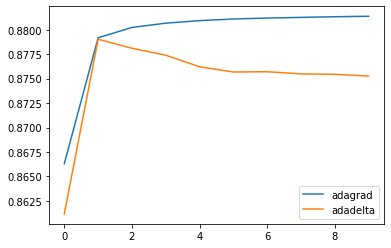

In [41]:
x = np.arange(len(adagrad_auc))
plt.plot(x, np.array(adagrad_auc))
plt.plot(x, np.array(adadelta_auc))
plt.legend(['adagrad', 'adadelta'], loc='lower right')
plt.show()

<h3 style="color:yellow;background-color:blue">Adagrad seems to be way better than Adadelta, so we prefer to use it</h3>

We can try the same for the k-OS loss.

In [43]:
# ADAGRAD (k-OS) --------------------------------
adagrad_model = LightFM(no_components=30,
                        loss='warp-kos',
                        learning_schedule='adagrad',
                        user_alpha=alpha, item_alpha=alpha)
adagrad_auc = []

for epoch in tqdm(range(epochs),desc="fitting adagrad (k-os)"):
    adagrad_model.fit_partial(URM_train_validation, epochs=1)
    adagrad_auc.append(auc_score(adagrad_model, URM_test).mean())

# ADADELTA (k-OS) --------------------------------
adadelta_model = LightFM(no_components=30,
                        loss='warp-kos',
                        learning_schedule='adadelta',
                        user_alpha=alpha, item_alpha=alpha)
adadelta_auc = []

for epoch in tqdm(range(epochs),desc="fitting adadelta (k-os)"):
    adadelta_model.fit_partial(URM_train_validation, epochs=1)
    adadelta_auc.append(auc_score(adadelta_model, URM_test).mean())

fitting adadelta (k-os): 100%|██████████| 10/10 [04:56<00:00, 29.67s/it]


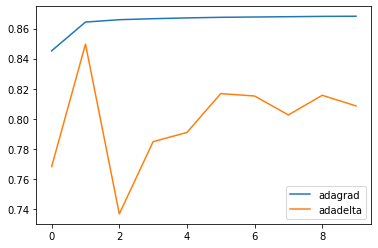

In [44]:
x = np.arange(len(adagrad_auc))
plt.plot(x, np.array(adagrad_auc))
plt.plot(x, np.array(adadelta_auc))
plt.legend(['adagrad', 'adadelta'], loc='lower right')
plt.show()

<h3 style="color:yellow;background-color:blue"> mmmkay, I don't even know what WARP-kos actually does, but I guess Adadelta still sucks so who cares, we will stick to Adagrad</h3>

<h2 style="color:yellow;background-color:darkgreen"> RECAP: we will use WARP as loss funciton and Adagrad as schedule</h2>

fitting WARP model: 100%|██████████| 70/70 [25:21<00:00, 21.74s/it]


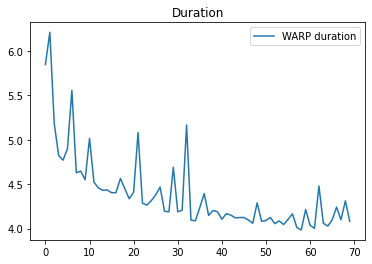

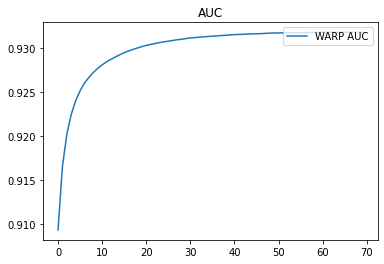

In [48]:
alpha = 1e-05
epochs = 70
num_components = 32

warp_model = LightFM(no_components=num_components,
                     max_sampled=3,
                    loss='warp',
                    learning_schedule='adagrad',
                    user_alpha=alpha,
                    item_alpha=alpha)

warp_duration = []
warp_auc = []

for epoch in tqdm(range(epochs), desc="fitting WARP model")  :
    start = time.time()
    warp_model.fit_partial(URM_train_validation, epochs=1)
    warp_duration.append(time.time() - start)
    warp_auc.append(auc_score(warp_model, URM_test, train_interactions=URM_train_validation).mean())

x = np.arange(epochs)
plt.plot(x, np.array(warp_duration))
plt.legend(['WARP duration'], loc='upper right')
plt.title('Duration')
plt.show()

x = np.arange(epochs)
plt.plot(x, np.array(warp_auc))
plt.legend(['WARP AUC'], loc='upper right')
plt.title('AUC')
plt.show()

In [21]:
# In order to evaluate put it in a recommender class
class LightFMWrapper(BaseRecommender):
    """LightFMWrapper"""

    RECOMMENDER_NAME = "LightFMWrapper"

    def __init__(self, URM_train):
        super(LightFMWrapper, self).__init__(URM_train)


    def fit(self, ITEM_ALPHA, NUM_COMPONENTS, NUM_EPOCHS, NUM_THREADS):
        
        # Let's fit a WARP model
        self.lightFM_model = LightFM(loss='warp',
                                     item_alpha=ITEM_ALPHA,
                                     no_components=NUM_COMPONENTS)

        self.lightFM_model = self.lightFM_model.fit(URM_train, 
                                                    epochs=NUM_EPOCHS,
                                                    num_threads=NUM_THREADS)


    def _compute_item_score(self, user_id_array, items_to_compute = None):
        
        # Create a single (n_items, ) array with the item score, then copy it for every user
        items_to_compute = np.arange(self.n_items) if items_to_compute is None else np.array(items_to_compute)
        
        item_scores = - np.ones((len(user_id_array), self.n_items)) * np.inf

        for user_index, user_id in enumerate(user_id_array):
            item_scores[user_index] = self.lightFM_model.predict(int(user_id), 
                                                                 items_to_compute)

        return item_scores


In [31]:
# Set the number of threads; you can increase this
# if you have more physical cores available.
NUM_THREADS = 4
NUM_COMPONENTS = 10
NUM_EPOCHS = 3
ITEM_ALPHA = 1e-6

recommender = LightFMWrapper(URM_train, ICM_event)
recommender.fit(ITEM_ALPHA, NUM_COMPONENTS, NUM_EPOCHS, NUM_THREADS)

LightFMWrapper: URM Detected 1 ( 0.0%) items with no interactions.


In [32]:
result_dict, _ = evaluator_validation.evaluateRecommender(recommender)
result_dict

EvaluatorHoldout: Processed 13603 (100.0%) in 2.49 min. Users per second: 91


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_ITEM_CORRECT,COVERAGE_USER,COVERAGE_USER_CORRECT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.004573,0.004611,0.001393,0.001473,0.001483,0.014254,0.004777,0.002135,0.044108,0.014477,...,0.002215,0.996557,0.043956,0.001793,5.382108,0.970839,0.007227,0.43436,0.24796,0.03704


In [24]:
class LightFMWrapper(BaseRecommender):
    """LightFMWrapper"""

    RECOMMENDER_NAME = "LightFMWrapper"

    def __init__(self, URM_train, ICM_train):
        super(LightFMWrapper, self).__init__(URM_train)
        
        self.ICM_train = ICM_train.copy()


    def fit(self, ITEM_ALPHA, NUM_COMPONENTS, NUM_EPOCHS, NUM_THREADS):
        
        # Let's fit a WARP model
        self.lightFM_model = LightFM(loss='warp',
                                     item_alpha=ITEM_ALPHA,
                                     no_components=NUM_COMPONENTS)

        self.lightFM_model = self.lightFM_model.fit(URM_train, 
                                       item_features=self.ICM_train, 
                                       epochs=NUM_EPOCHS, 
                                       num_threads=NUM_THREADS)


    def _compute_item_score(self, user_id_array, items_to_compute = None):
        
        # Create a single (n_items, ) array with the item score, then copy it for every user
        if items_to_compute is None:
            items_to_compute = np.arange(self.n_items)
            item_features = self.ICM_train 
        else:     
            items_to_compute = np.array(items_to_compute)
            item_features = self.ICM_train[items_to_compute,:]
        
        item_scores = - np.ones((len(user_id_array), self.n_items)) * np.inf

        for user_index, user_id in enumerate(user_id_array):
            item_scores[user_index] = self.lightFM_model.predict(int(user_id), 
                                                                 items_to_compute,
                                                                 item_features = item_features)

        return item_scores


In [25]:
recommender = LightFMWrapper(URM_train, ICM_genres)
recommender.fit(ITEM_ALPHA, NUM_COMPONENTS, NUM_EPOCHS, NUM_THREADS)

result_dict, _ = evaluator_validation.evaluateRecommender(recommender)
result_dict

LightFMWrapper: URM Detected 1 ( 0.0%) items with no interactions.
EvaluatorHoldout: Processed 13603 (100.0%) in 13.74 sec. Users per second: 990


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_ITEM_CORRECT,COVERAGE_USER,COVERAGE_USER_CORRECT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.005513,0.00558,0.001588,0.00273,0.002761,0.026555,0.007408,0.002466,0.053077,0.02692,...,0.002436,0.996557,0.052894,0.001361,4.886134,0.95517,0.005486,0.394333,0.251741,0.038959
